# Writing efficient DOcplex code

In this notebook, we show how to improve efficiency of DOcplex models using five simple rules.

>This notebook is part of **[Prescriptive Analytics for Python](http://ibmdecisionoptimization.github.io/docplex-doc/)**
>
>It requires either an [installation of CPLEX Optimizers](http://ibmdecisionoptimization.github.io/docplex-doc/getting_started.html) or it can be run on [IBM Watson Studio Cloud](https://www.ibm.com/cloud/watson-studio/) (Sign up for a [free IBM Cloud account](https://dataplatform.cloud.ibm.com/registration/stepone?context=wdp&apps=all>)
and you can start using Watson Studio Cloud right away).

## A simple timing tool

To measure performance we need a simple timing tool. For this purpose, we chose to implement a Python context manager object (see https://docs.python.org/3/reference/datamodel.html#context-managers) for details.

This object stores the start time when entering a block and reports time spent when exiting the block. Python's `with` statement avoids cluttering code with intrusive prints.

In [1]:
import time
import math

class ContextTimer(object):
    def __init__(self, msg):
        self.msg = msg
        self.start = 0
        
    def __enter__(self):
        self.start = time.time()
        print('--> begin {0}'.format(self.msg))
        return self  # return value is value of with ()
        
    def __exit__(self, *args):
        elapsed = time.time() - self.start
        self.msecs = math.ceil(1000* elapsed)
        print('<-- end {0},  time: {1:.0f} ms'.format(self.msg, self.msecs))   
        
# try our timer on computing fibonacci numbers
def fib(n):
    return 1 if n <= 2 else  fib(n-1) + fib(n-2)

# timing fibonacci(30)
with ContextTimer("fibonacci 30"):
    n = 30
    f = fib(n)
    print("fibonacci({0}) = {1}".format(n, f))
        

--> begin fibonacci 30
fibonacci(30) = 832040
<-- end fibonacci 30,  time: 231 ms


## The benchmark model

To compare various implementations, we need a simple, scalable benchmark model. The model has no real business meaning, but is simple to grasp
and can be scaled by changing one `size` parameter.
Note that we'll be comparing only the _build_ time of the model, not the _solve_ time.

Note that the model has _n_ constraints, all with expressions of size _N_, so we expect the underlying matrix _size_ to grow as $O(N^2)$.

### Description

Let $N$ be an integer (the size of the problem).

$$
minimize \sum_{k=0}^{k=N-1} (k+1) * y_{k}\\
s.t.\\
\forall\ \ m\ in \{0..N-1\}\ \ \sum_{l=0}^{l=N-1} (y_{l} * (l+ (l+m) \%3) \ge l\\
y_{k} = 0, 1\\
\\
\sum_{l} y_{l} \ge 2\\
$$

## A beginners's implementation of the model

In this section we show a Python/Docplex beginner's implementation of this model.


In [2]:
from docplex.mp.model import Model

def build_bench_model1(size=10):
    m = Model(name="bench1")
    rsize = range(size)
    # create variables as a dictionary indexed by the range
    ys = m.binary_var_dict(rsize, name="my_yvar")
    # create constraints
    k = {(i,j) : (i + (i+j) %3) for i in rsize for j in rsize}
    for i in rsize:
        m.add(m.sum(ys[i] * k[i,j] for j in rsize) >= i, "ct_sum_yjs_%d" %i)
    # for minimize, create a list of coefficients
    rsize1 = [i+1 for i in rsize]
    m.minimize(m.sum(ys[k] * rsize[k] for k in rsize))
    return m

Lets run our context timer with N=1000; we expect a model with 1000 variables and 1000 constraints:

In [3]:
with ContextTimer("bench1_size_1000"):
    m11k = build_bench_model1(1000)
m11k.print_information()

--> begin bench1_size_1000
<-- end bench1_size_1000,  time: 2724 ms
Model: bench1
 - number of variables: 1000
   - binary=1000, integer=0, continuous=0
 - number of constraints: 1000
   - linear=1000
 - parameters: defaults
 - problem type is: MILP


As expected the model has 1000 variables and 1000 constraints and the build time is significant.
For N=3000, we can expect an increase in buid time by a factor of 9, so you might as well go grab a coffee while this cell executes..

In [4]:
N=3000
with ContextTimer("bench1 size={0}".format(N)):
    build_bench_model1(N)

--> begin bench1 size=3000
<-- end bench1 size=3000,  time: 23384 ms


## Pitfall #1 : use Model.sum(), not Python sum()

In the above code, we compute the sum of variables using `Model.sum()`, not Python builtin function `sum`. One could wonder why Docplex had to redefine a specific sum function?

Python's um function calls the `+` operator repeatedly, that is, sum([x,y,z, t]) is evaluated as ((x+y)+z)+t. Calling `sum` with `N` arguments then creates `N` intermediate expressions, but there's more. Each intermediate expression has to be copied for the next sum, and as the size of the intermediate expressions grow, each copy takes an O(n) time, and th efinal sum has time in O(N^2).
On the opposite, `Model.sum()` creates only _one_ expression and incrementally adds each argument to it.

**Rule #1**: never use Python's builtin `sum` function to compute expressions,
 use `Model.sum()` instead.

Let's experiment with our benchmark model. First we define a variant function to build the same model as above with Python `sum`, and measure the two build times.

In [5]:
def build_bench_sum(size=10):
    m = Model(name="bench1")
    rsize = range(size)
    # create variables as a dictionary indexed by the range
    ys = m.binary_var_dict(rsize, name="my_yvar")
    # create constraints
    k = {(i,j) : (i + (i+j) %3) for i in rsize for j in rsize}
    for i in rsize:
        m.add(sum(ys[i] * k[i,j] for j in rsize) >= i, "ct_sum_yjs_%d" %i)
    # for minimize, create a list of coefficients
    rsize1 = [i+1 for i in rsize]
    m.minimize(sum(ys[k] * rsize[k] for k in rsize))
    return m

s = 1000
with ContextTimer("python_sum_too_slow_n=%d" % s):
    build_bench_sum(size=s)

with ContextTimer("same_model_with_model_sum_n=%d" % s):
    build_bench_model1(size=s)

--> begin python_sum_too_slow_n=1000
<-- end python_sum_too_slow_n=1000,  time: 4872 ms
--> begin same_model_with_model_sum_n=1000
<-- end same_model_with_model_sum_n=1000,  time: 2569 ms


Building the Python sum model takes roughly twice as much time as the model with `Model.sum()'.

#  Common tips to improve DOcplex code efficiency

## Tip #1: Use scalar product

When building large expressions,  scalar product (`Model.scal_prod()`) is 
an efficient way to combine a sequence of variables (or expressions)
and a sequence of coefficients.
Try using `scalar_prod` instead of using `for` loops in expressions.

In [6]:
def build_bench_model2(size=10):
    m = Model(name="bench2")
    rsize = range(size)
    # create variables as a dictionary indexed by the range
    ys = m.binary_var_dict(rsize, name="y")
    # create a matrix of coefficients
    k = {(i,j) : (i + (i+j) %3) for i in rsize for j in rsize}
    for i in rsize:
        m.add(m.scal_prod([ys[i1] for i1 in rsize], [k[i,j] for j in rsize]) >= i, "ct_%d" % i)
    # for minimize, create a list of coefficients
    rsize1 = [i+1 for i in rsize]
    m.minimize(m.scal_prod([ys[k] for k in rsize], rsize1))
    return m

with ContextTimer("bench2 size={0}".format(N)):
    build_bench_model2(N)

--> begin bench2 size=3000
<-- end bench2 size=3000,  time: 15968 ms


## Tip #2 (variant) : try functional scalar product (a.k.a. dotf)

Since DOcplex 2.9, Scalar product has a _functional_ variant, in which  coefficients are computed on the fly, with no need to prepare a (possibly large) container of numbers. In some cases, this can save a significant time.

The method is `Model.dotf` takes two arguments:

  - a dictionary of variables, as create by the Model.<type>_var_dict methods
  - a Python function that takes a variable key and returns a float, the coefficient
  
In our example, keys are the integer from 0 to `size-1` .
The coefficient for y_j in the i_th constraint is i+(i+j)%3: here we do not need
to precompute a list or a comprehension, but only use a lambda function to compute this.

We also leverage `dotf` for the objective, where the cost coefficient for y_j is (j+1)

In [7]:
def build_bench_model3(size=10):
    m = Model(name="bench3")
    rsize = range(size)
    # create variables as a dictionary indexed by the range
    ys = m.binary_var_dict(rsize, name="y")
    # no need to build an explicit matrix
    #k = {(i,j) : (i + (i+j) %3) for i in rsize for j in rsize}
    for i in rsize:
        # the ith function is a function oj returning (i+(i+j)%3)
        fi = lambda j_: i + (i+j_) % 3
        m.add(m.dotf(ys, fi) >= i, "ct_%d" % i)
    m.minimize(m.dotf(ys, lambda j_: j_ +1))
    return m

with ContextTimer("bench3 size={0}".format(N)):
    build_bench_model3(N)

--> begin bench3 size=3000
<-- end bench3 size=3000,  time: 9406 ms


## Tip #3: Add constraints in batches

Adding constraints to the model by batches using `Model.add_constraints()`
is usually more efficient.
Try grouping constraints in lists or comprehensions (both work).

If the constraints are named, pass a second argument with the collection of constraint names.

Note that `Model.add` runs `Model.add_constraints` if passed an iterable.

In [8]:
def build_bench_model4(size=10):
    m = Model(name="bench4")
    rsize = range(size)
    # create variables as a dictionary indexed by the range
    ys = m.binary_var_dict(rsize, name="y")
    # create constraints
    m.add_constraints((m.dotf(ys, lambda j_: i + (i+j_) % 3) >= i for i in rsize),
         ("ct_%d" % i for i in rsize))
    m.minimize(m.dotf(ys, lambda j_: j_ +1))
    return m

with ContextTimer("bench4 size={0}".format(N)):
    build_bench_model4(N)

--> begin bench4 size=3000
<-- end bench4 size=3000,  time: 10174 ms


## Tip #4: take control of name generation

Naming variables and/or constraints is useful to generate readable LP files. However, generating large numbers of strings may have a significant cost in Python, especially for large models. 

Passing `ignore_names=True` at model creation time, disables all name generation (variables and constraint names alike) everywhere in the model. 

By default, names are active and this flag is  `False`.


In [9]:
def build_bench_model5(size=10):
    m = Model(name="bench5", ignore_names=True)
    rsize = range(size)
    # create variables as a dictionary indexed by the range
    ys = m.binary_var_dict(rsize, name="y")
    # create constraints
    m.add((m.dotf(ys, lambda j_: i + (i+j_) % 3) >= i for i in rsize),
         ("ct_%d" % i for i in rsize))
    m.minimize(m.dotf(ys, lambda j_: j_ +1))
    return m

with ContextTimer("bench5 size={0}".format(N)):
    build_bench_model5(N)

--> begin bench5 size=3000
<-- end bench5 size=3000,  time: 10753 ms


## Tip #5: take control of argument checking

DOcplex usually checks the argumens passed to methods. As this can be useful when writing the model to avoid errors, this checking comes with a runtime cost. When running a deployed model that has been thoroughly tested and tuned, you can remove all checks by adding the `checker="off"` keyword argument to the model constructor.

Again, the next version is identical to the previous one , except that type-checking has been disabled.

In [15]:
def build_bench_model6(size=10):
    m = Model(name="bench6", ignore_names=True, checker='off')
    rsize = range(size)
    # create variables as a dictionary indexed by the range
    ys = m.binary_var_dict(rsize, name="y")
    # create constraints
    m.add((m.dotf(ys, lambda j_: i + (i+j_) % 3) >= i for i in rsize),
         ("ct_%d" % i for i in rsize))
    m.add(m.sum(ys) >= 2, "sum_ys_ge_2")
    m.minimize(m.dotf(ys, lambda j_: j_ +1))
    return m

with ContextTimer("bench6 size={0}".format(N)):
    build_bench_model6(N)

--> begin bench6 size=3000
<-- end bench6 size=3000,  time: 7172 ms


## Tip #6: experiment with Model.sum_vars

`Model.sum_vars()` expects only variables as arguments. Although it speeds up expression building, it may cause errors when checker is disabled.

In [26]:
def build_bench_model7(size=10):
    m = Model(name="bench7", ignore_names=True, checker='off')
    rsize = range(size)
    # create variables as a dictionary indexed by the range
    ys = m.binary_var_dict(rsize, name="y")
    # create constraints
    m.add((m.dotf(ys, lambda j_: i + (i+j_) % 3) >= i for i in rsize),
         ("ct_%d" % i for i in rsize))
    m.add(m.sum_vars_all_different(ys) >= 2, "sum_vars_ys_ge_2")
    m.minimize(m.dotf(ys, lambda j_: j_ +1))
    return m

with ContextTimer("bench7 size={0}".format(N)):
    build_bench_model7(N)

--> begin bench7 size=3000
<-- end bench7 size=3000,  time: 6860 ms


# Summary

From version 1 to version 6 , model build time has decreased from 35s to 4s (on our platform). Results may well differ on other platforms, but still, this demonstrates that the way the model is built can greatly influence the performance.

Here is a list of tricks to try to improve model building time:

 - Use Model.scal_prod wherever possible
 - Try using Model.dotf when applicable.
 - Add constraints in batches, not one by one
 - Try ignoring name generation (for large models)
 - Try disabling argument checking


## Plotting the trend

In this section we compute the times to build different model versions on various sizes, and
plot the result on a graph.
This code requires the `matplotlib` library to run.

**Note**: the next cell might take a significant time to run, as it
runs a lot of (size, model_build_function) combinations...

In [27]:
# various sizes to sample performance
sizes = [100, 300, 600, 1000, 3000, 5000]

# a lits of tuples (fn, label) to build model and an explanatory label
builders = [(build_bench_model1, "initial"), 
            (build_bench_model2, "scal_prod"),
            (build_bench_model3, "dotf"),
            (build_bench_model4, "batch_cts"),
            (build_bench_model5, "ignore_names"),
            (build_bench_model6, "names_checker_off"),
            (build_bench_model7, "sum_vars")
           ]
print("* start computing performance data")
res = {}
print("* start computing results...")
nb_runs = len(sizes) * len(builders)
r = 0
for s in sizes:
    for b, (bf, _) in enumerate(builders):
        r +=1 
        with ContextTimer("[{2}/{3}] use {0} with size={1}"
                          .format(bf.__name__, s, r, nb_runs)) as tt:
            m = bf(s)
            m.end()
        elapsed = tt.msecs
        res[b, s] = tt.msecs
print("* end computing results")
# now we have a dict of (#builder, size) -> time

* start computing performance data
* start computing results...
--> begin [1/42] use build_bench_model1 with size=100
<-- end [1/42] use build_bench_model1 with size=100,  time: 1116 ms
--> begin [2/42] use build_bench_model2 with size=100
<-- end [2/42] use build_bench_model2 with size=100,  time: 39 ms
--> begin [3/42] use build_bench_model3 with size=100
<-- end [3/42] use build_bench_model3 with size=100,  time: 27 ms
--> begin [4/42] use build_bench_model4 with size=100
<-- end [4/42] use build_bench_model4 with size=100,  time: 23 ms
--> begin [5/42] use build_bench_model5 with size=100
<-- end [5/42] use build_bench_model5 with size=100,  time: 23 ms
--> begin [6/42] use build_bench_model6 with size=100
<-- end [6/42] use build_bench_model6 with size=100,  time: 21 ms
--> begin [7/42] use build_bench_model7 with size=100
<-- end [7/42] use build_bench_model7 with size=100,  time: 19 ms
--> begin [8/42] use build_bench_model1 with size=300
<-- end [8/42] use build_bench_model1 wi

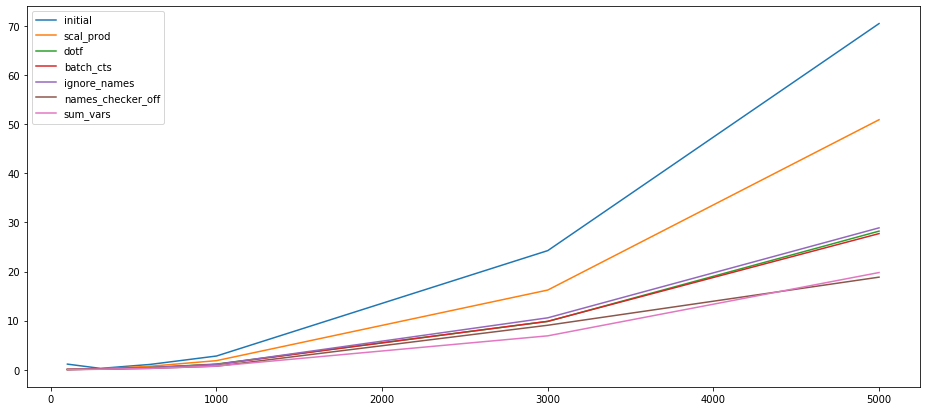

In [28]:
try:
    import matplotlib.pyplot as plt
    %matplotlib inline
except ImportError:
    print("try install matplotlib: pip install matplotlib")
    raise


labels = [ bl for (_, bl) in builders]
plt.figure(figsize=(16,7))
for b in range(len(builders)):
    bts = [res[b,s]/1000 for s in sizes]
    plt.plot(sizes, bts, label=labels[b])
    plt.legend()

plt.show()

## Average improvement

In the next cell, we compute the geometric mean of improvment between the first and last versions. Of course, results may differ depending on platform (and the model, too) but the idea is, applying the above rules may yield a significant improvement

In [13]:
# compute geomerical mean for all sizes
nb_builders = len(builders)
ratios = {}
for s in sizes:
    initial = res[0, s]
    # compute best over all builds
    best = min(res[b, s] for b in range(nb_builders))
    r = (initial/best)
    ratios[s] = r
import math
rgm = math.exp(sum(math.log(r) for r in ratios.values()) / float(nb_builders))
print("* geometric mean of time improvement is {0:.1f}".format(rgm))

* geometric mean of time improvement is 3.9


Copyright &copy; 2017-2019 IBM. IPLA licensed Sample Materials.